# Load Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data from Prvious Model

In [ ]:
import numpy as np
import tensorflow as tf
import cvxpy as cp
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import least_squares
import torch
import torch.nn as nn

train_data = np.load("/content/drive/My Drive/Dataset/NN/scoping_train.npz")
# print(train_data)

X = tf.constant(train_data['X'])
alpha = train_data['alpha']
sig = train_data['stddev']
num_pts_region = {(1, 1): 0, (1, -1): 0, (-1, 1): 0, (-1, -1): 0}
s_X = np.sign(pen_target(X).numpy()).astype(int)
for sign in s_X:
  num_pts_region[tuple(sign)] += 1

# 2 Layer NN

## Build Environment

In [ ]:
import numpy as np
import tensorflow as tf
import cvxpy as cp
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import least_squares
import torch
import torch.nn as nn

np.random.seed(67) ## (50, 5) -> 346 arms, (88, 9) -> 18 arms, (8, 10)-> 191 arms (good imshow), (67, 5) -> 794 arms, 
tf.random.set_seed(5)


num_dims = 2
# # dont set alpha to 0, but can set it very small
# # to work nice with np.sign function
alpha = 1e-6 #0.3 # default neg arm slope in leaky relu #
initializer = keras.initializers.RandomNormal()  # When Running the first time, uncomment the target model
target_model = keras.Sequential([
   keras.Input(shape=(num_dims)),
   layers.Dense(2, bias_initializer=initializer), 
   layers.LeakyReLU(alpha=alpha, name="penultimate"),
   layers.Dense(1, kernel_initializer=tf.keras.initializers.Ones(), 
                use_bias=False, trainable=False)
])


dyn_target_model = keras.Sequential([
   keras.Input(shape=(num_dims)),
   layers.Dense(2, bias_initializer=initializer), 
   layers.LeakyReLU(alpha=alpha, name="penultimate"),
   layers.Dense(1, kernel_initializer=tf.keras.initializers.Ones(), 
                use_bias=False, trainable=False)
])


chernoff_e_target_model = keras.Sequential([
   keras.Input(shape=(num_dims)),
   layers.Dense(2, bias_initializer=initializer), 
   layers.LeakyReLU(alpha=alpha, name="penultimate"),
   layers.Dense(1, kernel_initializer=tf.keras.initializers.Ones(), 
                use_bias=False, trainable=False)
])



# load a model from previous run
# target_model = keras.models.load_model("scoping_target_model")
# target_model.layers[-1].trainable = False   
# hack for a quirk of saving keras model: trainable attribute is lost but name is saved


pen_target = keras.Model(
    inputs=target_model.input, 
    outputs=target_model.get_layer('penultimate').output
)

dyn_pen_target = keras.Model(
    inputs=dyn_target_model.input, 
    outputs=dyn_target_model.get_layer('penultimate').output
)

chernoff_e_pen_target = keras.Model(
    inputs=chernoff_e_target_model.input, 
    outputs=chernoff_e_target_model.get_layer('penultimate').output
)

# generate points at random and reject more from a particular region,
# say from (1, -1) and (-1, 1)



X = []
reject_from = set([(1, -1), (-1, 1)])
num_pts_region = {(1, 1): 0, (1, -1): 0, (-1, 1): 0, (-1, -1): 0}
while min([num_pts_region[s] for s in reject_from]) < num_dims + 1:
   sample = 2 * np.random.random_sample((1, num_dims)) - 1
   sample = sample/np.linalg.norm(sample)
   samp_sign = tuple(np.sign(pen_target(sample).numpy().flatten()).astype(int))
   if samp_sign not in reject_from:
       num_pts_region[samp_sign] += 1
       X.append(sample)
   elif samp_sign == (1, -1) and (np.random.random_sample() < 0.1):
       num_pts_region[samp_sign] += 1
       X.append(sample)      
   elif samp_sign == (-1, 1) and (np.random.random_sample() < 0.1):
       num_pts_region[samp_sign] += 1
       X.append(sample)      
        
X = tf.constant(np.vstack(X))





def activation(arr, alpha):
    pre = arr.flatten()
    for idx, val in enumerate(pre):
        a = 1 if val > 0 else alpha
        pre[idx] = a * val
    return pre.reshape(arr.shape)

def two_relu_residuals(arr, x_vals, y_vals):  # Takes array of current weights [arr], the [x_vals] and [y_vals] are training dataset
    weights = arr.reshape((num_dims + 1, 2))
    arms_and_bias = np.hstack([x_vals, np.ones((len(x_vals), 1))])
    pre_activation = arms_and_bias @ weights
    # post_activation = np.heaviside(pre_activation, 0) * pre_activation
    post_activation = activation(pre_activation, alpha)
    y_pred = np.sum(post_activation, axis=1, keepdims=True)
    return np.array(y_vals - y_pred).flatten()

print(X.shape)

# estimation error performance of static strategies
sig = 0.01
num_trials = 10
num_repeats_per_pt = 1500






(794, 2)


# Run Algorithms

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(50)
tf.random.set_seed(5)


### Chernoff Proportion ###

def max_kmin_eig(rows_of_arms, k=1, verbose=False):
    p = cp.Variable(rows_of_arms.shape[0], nonneg=True)  
    prob = cp.Problem(
        cp.Maximize(cp.lambda_sum_smallest(
            rows_of_arms.T @ cp.diag(p) @ rows_of_arms, k)),
        [cp.sum(p) ==1]
    )
    try:
        obj_value = prob.solve(verbose=verbose)
        if prob.status == "optimal":
            return p.value, prob.value
        else:
            obj_value = prob.solve(solver='CVXOPT', 
                    kktsolver=cp.ROBUST_KKTSOLVER, verbose=verbose)
            return p.value, prob.value
    
    except Exception as inst:
        print(inst)
        return False, inst

### ActiveS Proportion Calculation ###

def solve_optimization(self, theta1, X, m2 = 5):

      
    d = num_dims
    X_sampled = np.copy(X)
    X_sampled = X_sampled.T
    IU_theta1 = np.zeros((d, d))
  
    for i in range(num_arms):
      # ext = np.exp( np.matmul(X_sampled[:, i:i+1].T, theta1)) ## Uncomment next two lines for GLM
      # val = ext /((1.0 + ext)**2) * np.matmul(X_sampled[:, i:i+1], X_sampled[:, i:i+1].T)
      val = np.matmul(X_sampled[:, i:i+1], X_sampled[:, i:i+1].T) # Linear
      IU_theta1 = IU_theta1 + val
      
    u, e, v = np.linalg.svd(IU_theta1)
    e = e.reshape(-1, 1)
    a = cp.Variable((num_arms, 1))
    c = cp.Variable((d, 1))
    S = np.zeros((d, d))
    for i in range(num_arms):
      # ext = np.exp( np.matmul(X_sampled[:, i:i+1].T, theta1)) ## Uncomment next two lines for GLM
      # S = S + a[i, 0] * ext /((1.0 + ext)**2) * cp.matmul(X_sampled[:, i:i+1], X_sampled[:, i:i+1].T)
      
      S = S + a[i, 0] * cp.matmul(X_sampled[:, i:i+1], X_sampled[:, i:i+1].T) # Linear

    
    
    constraints = [a >= 0]
    constraints += [a <= 1]
    constraints += [cp.sum(a) == m2]

    for j in range(d):
      constraints += [cp.matrix_frac(v[:, j], S) <= c[j, 0]]

    prob = cp.Problem(cp.Minimize(e.T @ c), constraints)
    prob.solve()
    return a.value


def get_gamma_bar(init_weight, x_vals, y_vals, flag = False):

    # Solve Optimization
          
    theta1 = init_weight
    # print("theta1: ", theta1)

    m2 = 2
    a_star = solve_optimization(theta1, x_vals, y_vals, m2)
    
    # print("as:, ", a_star)
    
    alpha = 1 - (np.power(100, -1.0/6.0))

    if a_star is None:
      a_star = np.copy(p_unif)
      flag = True
    
    gamma1 = a_star/m2


    gamma_bar = np.zeros(num_arms)

    # Calculate distribution, 

    for k in range(num_arms):

      gamma_bar[k] += alpha*(gamma1[k]) + (1.0 - alpha)*p_unif[k]

    gamma_bar = np.abs(gamma_bar)
    gamma_bar = gamma_bar/np.sum(gamma_bar)
    # print(gamma_bar)
    return gamma_bar, flag





    
class MyModel(nn.Module):
  def __init__(self, init_weight, alpha):
    super(MyModel, self).__init__()
    self.weights = nn.Parameter(init_weight.reshape((3, 2)))
    self.relu1 = nn.LeakyReLU(alpha)

  def forward(self, x_vals):
    arms_and_bias = torch.cat((x_vals, torch.ones((x_vals.shape[0], 1), device=x_vals.device)), dim=1)
    pre_activation = torch.matmul(arms_and_bias, self.weights) # (4, 3) * (3, 2)
    post_activation = self.relu1(pre_activation)
    y_pred = torch.sum(post_activation, dim=1, keepdims=True)
    return y_pred



def solve_weights(init_weight, x_vals, y_vals, alpha, name, viz_step = 1000):
    init_weight = torch.tensor(init_weight, dtype=torch.float).clone()
    x_vals = torch.tensor(x_vals, dtype=torch.float)
    y_vals = torch.tensor(y_vals, dtype=torch.float)
    model = MyModel(init_weight, alpha)

    # optim = torch.optim.SGD(model.parameters(), lr=1e-3)
    # optim = torch.optim.ASGD(model.parameters(), lr=1e-3)
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optim = torch.optim.LBFGS(model.parameters(), max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

    mse_loss = torch.nn.MSELoss()

    # Uncomment to run on GPU
    # device = torch.device('cuda:0')
    # model = model.to(device)
    # x_vals = x_vals.to(device)
    # y_vals = y_vals.to(device)
    # mse_loss = mse_loss.to(device)

    num_epochs = 50
    model.train()
    for i in range(num_epochs):
        y_pred = model(x_vals)
        loss = mse_loss(y_pred, y_vals)
        # if i % viz_step == 0:
        #     print(f'Epoch {i}, {name}: {loss}')
        model.zero_grad()
        loss.backward()
        optim.step()
    return model.weights.detach().clone().cpu().reshape((-1))






num_arms, num_dims = X.shape


p_unif = np.array([1.0/num_arms for i in range(num_arms)])
est_err = np.zeros((5, num_trials, num_repeats_per_pt)) 


Y = target_model(X) # Y is the arm means, no noise in it
target_w = np.vstack([w.numpy() for w in target_model.trainable_weights]) # This is theta star
true_signs = tuple(np.sign(pen_target(X).numpy().flatten()).astype(int))



dyn_target_w = np.vstack([w.numpy() for w in dyn_target_model.trainable_weights]) # This is theta star


# get the grads first -- for chernoff proportion
all_grads = []
for arm in range(num_arms):
    with tf.GradientTape() as arm_tape:
        y = target_model(tf.reshape(X[arm], (-1, num_dims))) # 
    
    grad = arm_tape.gradient(y, target_model.trainable_weights) #
    all_grads.append(np.concatenate([g.numpy().flatten() for g in grad]))
all_grads = np.array(all_grads)
# find the sampling proportion
small_eigs = sum(np.linalg.eigvalsh(all_grads.T @ all_grads) < 1e-10)
p_chernoff, v = max_kmin_eig(all_grads, 1 + small_eigs)




# first 3 are static strategies: round-robin, balanced-region, chernoff
# last is dynamic chernoff strategy

for tr in range(num_trials):
    print("Starting", tr)
    # to avoid using vstack across steps -- preallocate memory
    rr_X = np.zeros((num_arms * num_repeats_per_pt, num_dims))
    rr_Y = np.zeros((num_arms * num_repeats_per_pt, 1))

    chernoff_X = np.zeros((num_arms * num_repeats_per_pt, num_dims))
    chernoff_Y = np.zeros((num_arms * num_repeats_per_pt, 1))

    chernoff_e_X = np.zeros((num_arms * num_repeats_per_pt, num_dims))
    chernoff_e_Y = np.zeros((num_arms * num_repeats_per_pt, 1))

    activeS_X = np.zeros((num_arms * num_repeats_per_pt, num_dims))
    activeS_Y = np.zeros((num_arms * num_repeats_per_pt, 1))

    # for dynamic chernoff strategy
    dyn_chernoff_X = np.zeros((num_arms * num_repeats_per_pt, num_dims))
    dyn_chernoff_Y = np.zeros((num_arms * num_repeats_per_pt, 1))
    
    
    maxmin_eig_model = keras.Sequential([
        keras.Input(shape=(num_dims)),
        layers.Dense(2, bias_initializer=initializer), 
        layers.LeakyReLU(alpha=alpha, name='penultimate'),
        layers.Dense(1, kernel_initializer=tf.keras.initializers.Ones(), 
                     use_bias=False, trainable=False)
    ])
    pen_maxmin = keras.Model(
        inputs=maxmin_eig_model.input, 
        outputs=maxmin_eig_model.get_layer('penultimate').output
    )
    p_mm_dict = {}
    
    
    
    stage_shift = 0
    stage_shift_time = 20
    viz_step = 1000
    batch = 75

    p_chernoff_dyn = np.copy(p_unif)
    p_chernoff_e = np.copy(p_unif)

    # rand_start = target_w.flatten() + np.random.uniform(-0.001, 0.001, (6))
    # rand_start1 = target_w.flatten() + np.random.uniform(-0.001, 0.001, (6))
    # rand_start2 = target_w.flatten() + np.random.uniform(-0.001, 0.001, (6))

    rand_start = target_w.flatten() + np.random.uniform(-0.02, 0.02, (6))
    rand_start1 = target_w.flatten() + np.random.uniform(-0.001, 0.001, (6))
    rand_start2 = target_w.flatten() + np.random.uniform(-0.01, 0.01, (6))

    
    rslt_x_u = rand_start
    rslt_x_dc = rand_start1
    rslt_x_ce = rand_start1
    rslt_x_as = rand_start2
    

    

    for step in range(num_repeats_per_pt):
        # print('rr')

        # rand_start = target_w.flatten()
        
        # round-robin

        rr_arms = np.random.choice(
            num_arms, size=num_arms, p=p_unif
        )
        r_X = tf.stack([X[arm] for arm in rr_arms])
        r_Y = target_model(r_X) + tf.random.normal([num_arms, 1], stddev=sig)

        rr_X[step*num_arms : (step+1)*num_arms, :] = r_X.numpy()
        rr_Y[step*num_arms : (step+1)*num_arms, :] = r_Y.numpy()
        
        # est_err[0, tr, step] = np.linalg.norm(rslt.x - target_w.flatten())
        # print('least_sq', np.linalg.norm(rslt.x - target_w.flatten()))

        if step % batch == 0:
          rslt_x_u = solve_weights(rslt_x_u, rr_X[:(step+1)*num_arms, :], 
                                  rr_Y[:(step+1)*num_arms, :], alpha, name = "Unif", viz_step = viz_step)
          # opt_soln = least_squares(
          #   two_relu_residuals, rand_start, method='lm', 
          #   args=(rr_X[:(step+1)*num_arms, :], rr_Y[:(step+1)*num_arms, :])
          # )
          # rslt_x_u = opt_soln["x"]

        if step == stage_shift_time - 1:
          save_for_active_S = rslt_x_u
          
          
        est_err[0, tr, step] = np.linalg.norm(rslt_x_u - target_w.flatten())


        
        # chernoff with optimal theta_star
        # print('cher')
        chernoff_arms = np.random.choice(
            num_arms, size=num_arms, p=p_chernoff/sum(p_chernoff)
        )
        c_X = tf.stack([X[arm] for arm in chernoff_arms])
        c_Y = target_model(c_X) + tf.random.normal([num_arms, 1], stddev=sig)
        
        chernoff_X[step*num_arms : (step+1)*num_arms, :] = c_X.numpy()
        chernoff_Y[step*num_arms : (step+1)*num_arms, :] = c_Y.numpy()
        
        
        #### For Chernoff keep target_w.flatten() ####

        if step % batch == 0:
          rslt_x_c = solve_weights(target_w.flatten(), chernoff_X[:(step+1)*num_arms, :], 
                                  chernoff_Y[:(step+1)*num_arms, :], alpha, name = "GC", viz_step = viz_step)
          # opt_soln = least_squares(
          #     two_relu_residuals, target_w.flatten(), method='lm', 
          #     args=(chernoff_X[:(step+1)*num_arms, :], chernoff_Y[:(step+1)*num_arms, :])
          # )
          # rslt_x_c = opt_soln["x"]
          
        est_err[1, tr, step] = np.linalg.norm(rslt_x_c - target_w.flatten())
        
        
        
        flag = False
        if step < stage_shift_time:
          p_activeS = np.copy(p_unif)
        elif step == stage_shift_time:
          
          p_activeS, flag = get_gamma_bar(save_for_active_S.flatten(), activeS_X[:(step+1)*num_arms, :], 
                                    activeS_Y[:(step+1)*num_arms, :], flag)
        elif step > stage_shift_time and flag == True:
          p_activeS, flag = get_gamma_bar(save_for_active_S.flatten(), activeS_X[:(step+1)*num_arms, :], 
                                    activeS_Y[:(step+1)*num_arms, :], flag)
        
        # ActiveS
        # print('actives')
        activeS_arms = np.random.choice(
            num_arms, size=num_arms, p=p_activeS
        )
        S_X = tf.stack([X[arm] for arm in activeS_arms])
        S_Y = target_model(S_X) + tf.random.normal([num_arms, 1], stddev=sig)
        
        activeS_X[step*num_arms : (step+1)*num_arms, :] = S_X.numpy()
        activeS_Y[step*num_arms : (step+1)*num_arms, :] = S_Y.numpy()
        
        if step % batch == 0:
          rslt_x_as = solve_weights(rslt_x_as, activeS_X[:(step+1)*num_arms, :], 
                                  activeS_Y[:(step+1)*num_arms, :], alpha, name = "AS", viz_step = viz_step)
          # opt_soln = least_squares(
          #     two_relu_residuals, rand_start, method='lm', 
          #     args=(activeS_X[:(step+1)*num_arms, :], activeS_Y[:(step+1)*num_arms, :])
          # )
          # rslt_x_as = opt_soln["x"]

        est_err[2, tr, step] = np.linalg.norm(rslt_x_as - target_w.flatten())
        
        stage_shift += 1

        ### Chernoff Exploration ###
        num = np.random.uniform(0,1)
        epsilon_s = 1.0/((step+1)**1.5)
        if epsilon_s < num:
          chernoff_e_arms = np.random.choice(
              num_arms, size=num_arms, p=p_unif)
        else:
          chernoff_e_arms = np.random.choice(
              num_arms, size=num_arms, p=p_chernoff_e/sum(p_chernoff_e)
          )

        CE_X = tf.stack([X[arm] for arm in chernoff_e_arms])
        CE_Y = target_model(CE_X) + tf.random.normal([num_arms, 1], stddev=sig)
        
        chernoff_e_X[step*num_arms : (step+1)*num_arms, :] = CE_X.numpy()
        chernoff_e_Y[step*num_arms : (step+1)*num_arms, :] = CE_Y.numpy()
        
        if step % batch == 0:
          rslt_x_ce = solve_weights(rslt_x_ce, chernoff_e_X[:(step+1)*num_arms, :], 
                                chernoff_e_Y[:(step+1)*num_arms, :], alpha, name = "GCE", viz_step = viz_step)
          # opt_soln = least_squares(
          #     two_relu_residuals, rand_start, method='lm', 
          #     args=(chernoff_e_X[:(step+1)*num_arms, :], chernoff_e_Y[:(step+1)*num_arms, :])
          # )
          # rslt_x_ce = opt_soln["x"] ## theta_hat

          chernoff_e_target_model.layers[0].set_weights([
                rslt_x_ce[:-2].reshape((num_dims, 2)), rslt_x_ce[-2:]
          ])


          # get the grads first -- for chernoff proportion
          all_grads_chernoff_e = []
          for arm in range(num_arms):
              with tf.GradientTape() as arm_tape_e:
                  y = chernoff_e_target_model(tf.reshape(X[arm], (-1, num_dims))) # 
              
              chernoff_e_grad = arm_tape_e.gradient(y, chernoff_e_target_model.trainable_weights) #
              all_grads_chernoff_e.append(np.concatenate([g.numpy().flatten() for g in chernoff_e_grad]))
          all_grads_chernoff_e = np.array(all_grads_chernoff_e)
          # find the sampling proportion
          small_eigs = sum(np.linalg.eigvalsh(all_grads_chernoff_e.T @ all_grads_chernoff_e) < 1e-10)
          p_chernoff_e, v = max_kmin_eig(all_grads_chernoff_e, 1 + small_eigs)

        est_err[3, tr, step] = np.linalg.norm(rslt_x_ce - target_w.flatten())

        
        
        ### Dyn Chernoff ####

        
        dyn_chernoff_arms = np.random.choice(
              num_arms, size=num_arms, p=p_chernoff_dyn/sum(p_chernoff_dyn)
        )

        dC_X = tf.stack([X[arm] for arm in dyn_chernoff_arms])
        dC_Y = target_model(dC_X) + tf.random.normal([num_arms, 1], stddev=sig)
        
        dyn_chernoff_X[step*num_arms : (step+1)*num_arms, :] = dC_X.numpy()
        dyn_chernoff_Y[step*num_arms : (step+1)*num_arms, :] = dC_Y.numpy()
        
        # if step <= 30:
        #   rslt_x_dc = solve_weights(, dyn_chernoff_X[:(step+1)*num_arms, :], 
        #                         dyn_chernoff_Y[:(step+1)*num_arms, :], alpha, name = "DGC", viz_step = viz_step)

        
        # if step > 30 or step % batch == 0:
        if step % batch == 0:
          rslt_x_dc = solve_weights(rslt_x_dc, dyn_chernoff_X[:(step+1)*num_arms, :], 
                                dyn_chernoff_Y[:(step+1)*num_arms, :], alpha, name = "DGC", viz_step = viz_step)
          # opt_soln = least_squares(
          #     two_relu_residuals, rand_start, method='lm', 
          #     args=(dyn_chernoff_X[:(step+1)*num_arms, :], dyn_chernoff_Y[:(step+1)*num_arms, :])
          # )
          # rslt_x_dc = opt_soln["x"] ## theta_hat

          dyn_target_model.layers[0].set_weights([
                rslt_x_dc[:-2].reshape((num_dims, 2)), rslt_x_dc[-2:]
          ])


          # get the grads first -- for chernoff proportion
          all_grads_dyn = []
          for arm in range(num_arms):
              with tf.GradientTape() as arm_tape_d:
                  y = dyn_target_model(tf.reshape(X[arm], (-1, num_dims))) # 
              
              dyn_grad = arm_tape_d.gradient(y, dyn_target_model.trainable_weights) #
              all_grads_dyn.append(np.concatenate([g.numpy().flatten() for g in dyn_grad]))
          all_grads_dyn = np.array(all_grads_dyn)
          # find the sampling proportion
          small_eigs = sum(np.linalg.eigvalsh(all_grads_dyn.T @ all_grads_dyn) < 1e-10)
          p_chernoff_dyn, v = max_kmin_eig(all_grads_dyn, 1 + small_eigs)

        est_err[4, tr, step] = np.linalg.norm(rslt_x_dc - target_w.flatten())

        

        if step % 50 == 0:
          # print(tr, step)
          print(f'Trial {tr}: {step}, U: {est_err[0, tr, step]}, GC: {est_err[1, tr, step]}, AS: {est_err[2, tr, step]}, GCE: {est_err[3, tr, step]}, dGC: {est_err[4, tr, step]},')
          # plt.plot(p_activeS)
          # plt.show()





Starting 0


TypeError: ignored

# Plot Error

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')

#plt.style.use('seaborn-muted')
plt.style.use('ggplot')
plt.figure(dpi=200)


print(est_err.shape)
labels = ['Unif', 'GC', 'ActiveS', 'GCE', 'DGC']
# labels = ['Unif', 'ActiveS', 'GCE', 'DGC']
for i in range(0,5):
  if i != 1:
    plt.plot(np.mean(est_err[i], axis=0), label=labels[i])
plt.legend()
plt.yscale("log")

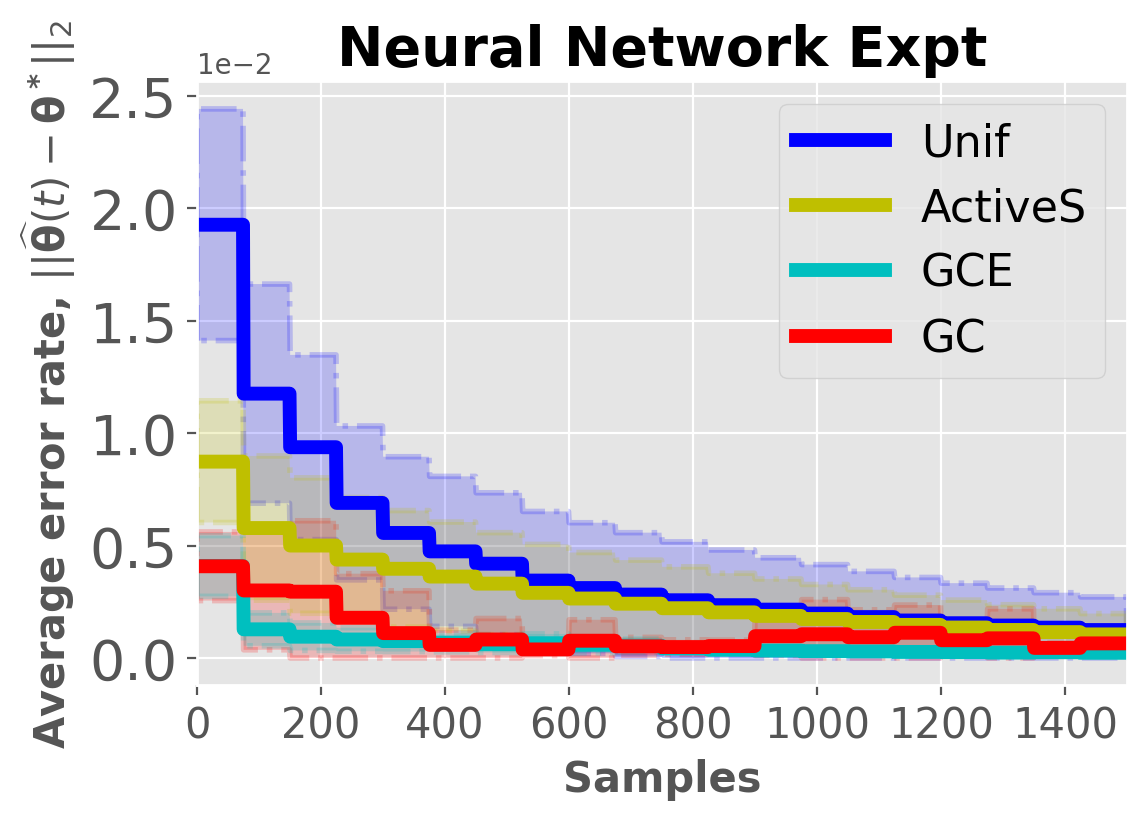

In [ ]:
# plot average errors
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')

#plt.style.use('seaborn-muted')
plt.style.use('ggplot')
plt.figure(dpi=200)

k = 1.0

# print(glm_activeS.error, glm_AASL.error)

plt.title('Neural Network Expt', size = 20, fontweight='bold')

# plt.plot(range(num_repeats_per_pt), np.average(est_err[1], axis=0), color = "r", linewidth = 6.0, label='OGC')

plt.plot(range(num_repeats_per_pt), np.average(est_err[0], axis=0), color = "b", linewidth = 5.0, label='Unif')
# plt.plot(range(env.T), np.average(emcm.error, axis=0), color = "g", linewidth = 5.0, label='EMCM')
plt.plot(range(num_repeats_per_pt), np.average(est_err[2], axis=0), color = "y", linewidth = 5.0, label='ActiveS')
plt.plot(range(num_repeats_per_pt), np.average(est_err[3], axis=0), color = "c", linewidth = 5.0, label='GCE')
plt.plot(range(num_repeats_per_pt), np.average(est_err[4], axis=0), color = "r", linewidth = 5.0, label='GC')

# plt.fill_between(range(num_repeats_per_pt), np.average(est_err[1], axis=0) + np.std(est_err[1], axis=0),np.clip(np.average(est_err[1], axis=0) - np.std(est_err[1], axis=0), a_min=0, a_max= None), alpha=0.2, edgecolor="r", facecolor="r", linewidth=2, linestyle='dashdot', antialiased=True)
plt.fill_between(range(num_repeats_per_pt), np.average(est_err[0], axis=0) + k*np.std(est_err[0], axis=0),np.clip(np.average(est_err[0], axis=0) - k*np.std(est_err[0], axis=0), a_min=0, a_max= None), alpha=0.2, edgecolor="b", facecolor="b", linewidth=2, linestyle='dashdot', antialiased=True)
plt.fill_between(range(num_repeats_per_pt), np.average(est_err[4], axis=0) + np.std(est_err[4], axis=0),np.clip(np.average(est_err[4], axis=0) - np.std(est_err[4], axis=0), a_min=0, a_max= None), alpha=0.2, edgecolor="r", facecolor="r", linewidth=2, linestyle='dashdot', antialiased=True)
# plt.fill_between(range(env.T), np.average(emcm.error, axis=0) + np.std(emcm.error, axis=0),np.clip(np.average(emcm.error, axis=0) - np.std(emcm.error, axis=0), a_min=0, a_max= None), alpha=0.2, edgecolor="g", facecolor="g", linewidth=2, linestyle='dashdot', antialiased=True)

plt.fill_between(range(num_repeats_per_pt), np.average(est_err[2], axis=0) + np.std(est_err[2], axis=0),np.clip(np.average(est_err[2], axis=0) - np.std(est_err[2], axis=0), a_min=0, a_max= None), alpha=0.2, edgecolor="y", facecolor="y", linewidth=2, linestyle='dashdot', antialiased=True)
plt.fill_between(range(num_repeats_per_pt), np.average(est_err[3], axis=0) + np.std(est_err[3], axis=0),np.clip(np.average(est_err[3], axis=0) - np.std(est_err[3], axis=0), a_min=0, a_max= None), alpha=0.2, edgecolor="c", facecolor="c", linewidth=2, linestyle='dashdot', antialiased=True)


legend_properties = {'weight':'bold'}
plt.legend(fontsize = 16)
plt.xticks(size = 15)
plt.yticks(size = 20)
plt.ylabel('Average error rate, $\\|\\|\widehat{\mathbf{\\theta}}(t) - \mathbf{\\theta^*}\\|\\|_2$', fontweight='bold', fontsize = 15)
plt.xlabel('Samples', fontweight='bold', fontsize = 15)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# plt.legend()
# plt.xticks(size = 10)
# plt.yticks(size = 10)
# plt.ylabel('Average error rate, $\\|\\|\widehat{\mathbf{\\theta}}(t) - \mathbf{\\theta^*}\\|\\|_2$')
# plt.xlabel('Samples')

# plt.ylim(0.28,0.3)
# plt.yscale("log")
#plt.grid()
plt.grid(b=True, which='major', linestyle='-')
plt.xlim(0,1500)
plt.show()

# Plot Error 1

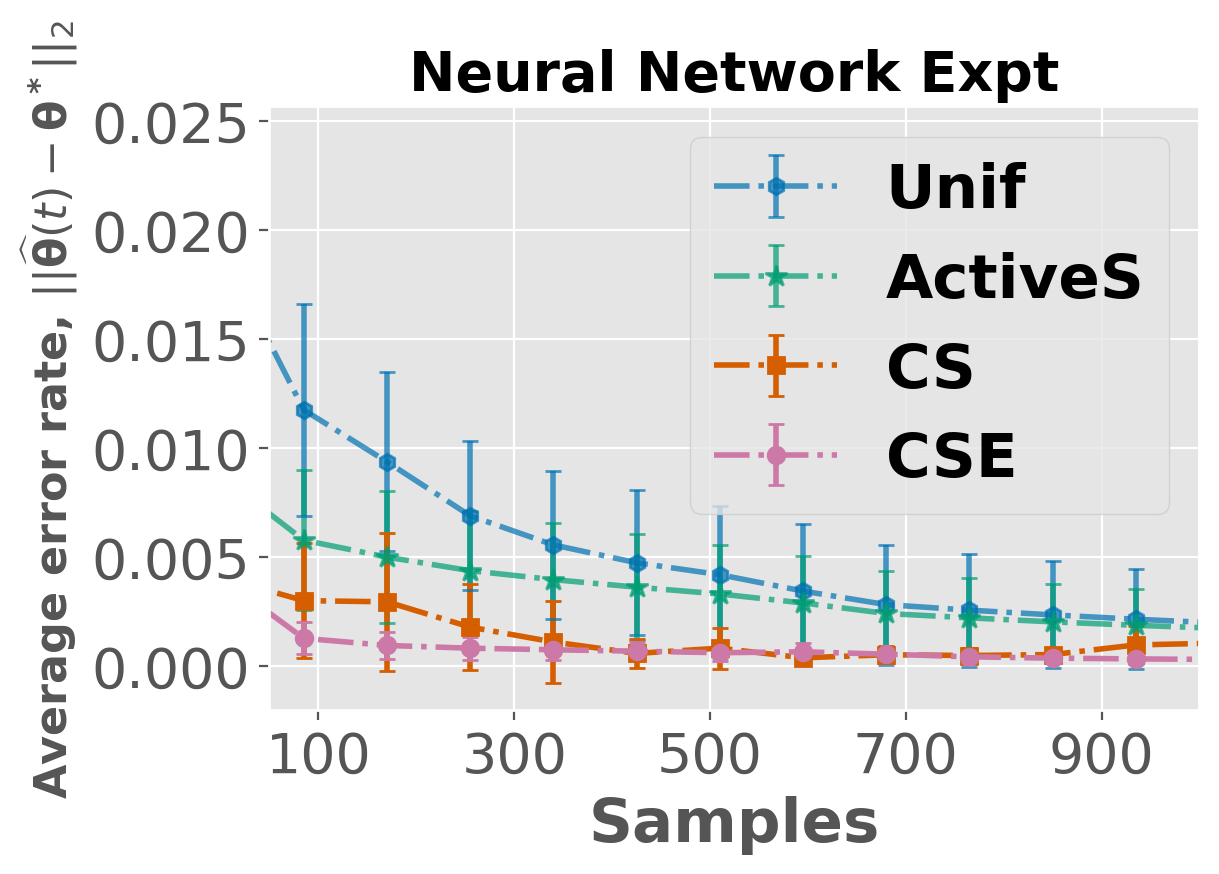

In [ ]:
# plot average errors
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')

#plt.style.use('seaborn-muted')
plt.style.use('ggplot')
plt.figure(dpi=200)


# print(glm_activeS.error, glm_AASL.error)

plt.title('Neural Network Expt', size = 20, fontweight='bold')

# print(num_repeats_per_pt)
scale = np.arange(0, num_repeats_per_pt, 85)



# plt.errorbar(scale, [np.average(est_err[0], axis=0)[i] for i in scale], [1.0*np.std(est_err[0], axis=0)[i] for i in scale], color = "b", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 0.7, label = "Unif")
# plt.errorbar(scale, [np.average(est_err[2], axis=0)[i] for i in scale], [1.0*np.std(est_err[2], axis=0)[i] for i in scale], color = "y", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 0.7, label='ActiveS')
# plt.errorbar(scale, [np.average(est_err[4], axis=0)[i] for i in scale], [1.0*np.std(est_err[4], axis=0)[i] for i in scale], color = "r", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 1.0, label='CS')
# plt.errorbar(scale, [np.average(est_err[3], axis=0)[i] for i in scale], [1.0*np.std(est_err[3], axis=0)[i] for i in scale], color = "c", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 1.0, label='CSE', solid_joinstyle = "bevel")

plt.errorbar(scale, [np.average(est_err[0], axis=0)[i] for i in scale], [1.0*np.std(est_err[0], axis=0)[i] for i in scale], color = "#0072B2", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 0.7, label = "Unif", linestyle = "-.", marker = "h", markersize = 6.0)
plt.errorbar(scale, [np.average(est_err[2], axis=0)[i] for i in scale], [1.0*np.std(est_err[2], axis=0)[i] for i in scale], color = "#009E73", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 0.7, label='ActiveS', linestyle = "-.", marker = "*", markersize = 8.0)
plt.errorbar(scale, [np.average(est_err[4], axis=0)[i] for i in scale], [1.0*np.std(est_err[4], axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 1.0, label='CS', linestyle = "-.", marker = "s", markersize = 6.0)
plt.errorbar(scale, [np.average(est_err[3], axis=0)[i] for i in scale], [1.0*np.std(est_err[3], axis=0)[i] for i in scale], color = "#CC79A7", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 1.0, label='CSE', linestyle = "-.", marker = "o", markersize = 6.0)


legend_properties = {'weight':'bold', 'size':22}
plt.legend(prop = legend_properties)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.ylabel('Average error rate, $\\|\\|\widehat{\mathbf{\\theta}}(t) - \mathbf{\\theta^*}\\|\\|_2$', fontweight='bold', fontsize = 16)
plt.xlabel('Samples', fontweight='bold', fontsize = 22)

# plt.ylim(0,1)
#plt.grid()
plt.grid(b=True, which='major', linestyle='-')
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
x_ticks = np.arange(100, num_repeats_per_pt, 200)
plt.xticks(x_ticks)
plt.xlim(50,1000)
plt.show()

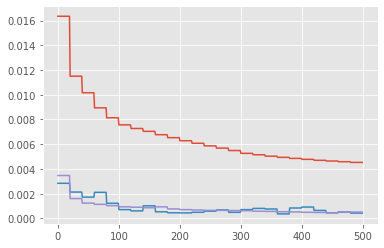

In [ ]:
est_err_unif = est_err[0]
est_err_GC = est_err[4]
est_err_GCE = est_err[3]

plt.plot(np.average(est_err_unif, axis = 0))
plt.plot(np.average(est_err_GC, axis = 0))
plt.plot(np.average(est_err_GCE, axis = 0))
plt.show()

# Model Save

In [ ]:
np.save("/content/drive/My Drive/Dataset/NN/scoping_rsltg3", est_err)
# need to also save model for later expts
np.savez("/content/drive/My Drive/Dataset/NN/scoping_traing3", X = X.numpy(), Y = Y.numpy(), stddev = sig, alpha = alpha)
target_model.save("/content/drive/My Drive/Dataset/NN/scoping_target_modelg3")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Dataset/NN/scoping_target_modelg3/assets


# File Save

In [ ]:
import pickle
file = open("/content/drive/My Drive/Dataset/NN/datascipy5gfinal1", 'wb')

A = est_err[1]
B = est_err[0]
C = est_err[4]
D = est_err[2]
# E = emcm.error
F = est_err[3]
# F = glm_top2.error

pickle.dump([A, B, C, D, F],file) # dump information to that file

file.close() # close the file

# File Load

In [ ]:
import pickle 
file = open("/content/drive/My Drive/Dataset/NN/datascipy5gfinal1", 'rb')
data = pickle.load(file)
file.close()

print(np.shape(data[0]))

est_err[1] = data[0]
est_err[0] = data[1]
est_err[4] = data[2]
est_err[2] = data[3]
# E = emcm.error
est_err[3] = data[4]



(10, 1500)


# Plot Proportions

(794,)


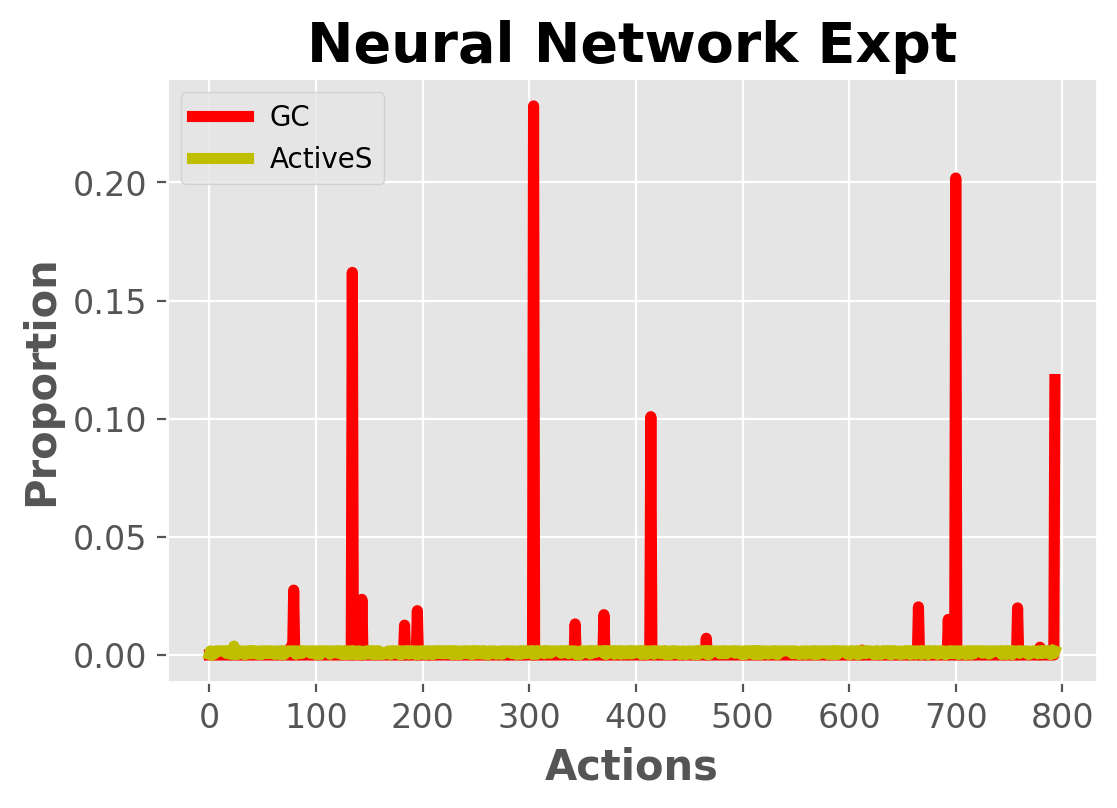

In [ ]:
print(np.shape(p_activeS))


plt.style.use('ggplot')
plt.figure(dpi=200)

plt.title('Neural Network Expt', size = 20, fontweight='bold')
plt.plot(p_chernoff, label = "GC", color = 'r', linewidth = 4.0)
plt.plot(p_activeS, label = "ActiveS", color = 'y', linewidth = 4.0)

plt.title('Neural Network Expt', size = 20, fontweight='bold')
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylabel('Proportion', fontweight='bold', fontsize = 15)
plt.xlabel('Actions', fontweight='bold', fontsize = 15)

plt.grid(b=True, which='major', linestyle='-')


plt.legend()


plt.legend()

# Plot Points

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

Y = target_model(X)
a, b = np.shape(Y)
Y1 = tf.reshape(Y, a)

print(np.shape(Y1))

print(np.shape(X))

# plt.scatter(X[:,0], X[:,1], c=np.sum(Y, axis=1), cmap='Wistia')
plt.scatter(X[:,0], X[:,1])

# plot background
x = np.linspace(-1,1,100)
y = np.linspace(-1,1,100)
data = np.matmul(x,y)
# plt.imshow(data)
xx, yy = np.meshgrid(x, y)
print(xx.shape, yy.shape)

z = np.concatenate( (xx.reshape(-1, 1),yy.reshape(-1, 1)), axis=1) # (10000, 2)
print(z.shape)
zout = np.array(target_model(z))
print(zout.shape)
print(np.min(zout), np.max(zout))
print(type(zout))
plt.imshow(zout.reshape(100,100), origin='lower', extent=[-1,1,-1,1], cmap='Wistia')
plt.colorbar()

# plot lines
target_w = np.vstack([w.numpy() for w in target_model.trainable_weights]) 
x1 = np.linspace(-1, 1, 100)
y1 = -(target_w[2, 0] + target_w[0, 0] * x1) / target_w[1, 0]

x2 = np.linspace(-1, 1, 100)
y2 = -(target_w[2, 1] + target_w[0, 1] * x2) / target_w[1, 1]

plt.plot(x1, y1, 'k', x2, y2, 'k')
plt.axis([-1, 1, -1, 1])


(794,)
(794, 2)
(100, 100) (100, 100)
(10000, 2)
(10000, 1)
-9.847206e-07 1.088439
<class 'numpy.ndarray'>


(-1.0, 1.0, -1.0, 1.0)

In [ ]:
# print(z[0:5])
# print(zout[0:5])
# zoutr = zout.reshape(100,100)
# zoutr[95:100, 95:100]

# xx1 = xx.reshape(-1, 1).reshape(100, 100)
# yy1 = yy.reshape(-1, 1).reshape(100, 100)
# print(xx1[0:5, 0:5])
# print(yy1[0:5, 0:5])

print(target_model(np.array([[1,1]])))

tf.Tensor([[0.34092504]], shape=(1, 1), dtype=float32)


# Debug

In [ ]:
import torch
import torch.nn as nn
import time

# x_vals -> F[weights] -> y_vals

x_vals = torch.ones((4, 2))
y_vals = torch.ones((4, 1))

class MyModel(nn.Module):
  def __init__(self, init_weight, alpha):
    super(MyModel, self).__init__()
    self.weights = nn.Parameter(init_weight.reshape((3, 2)))
    self.relu1 = nn.LeakyReLU(alpha)

  def forward(self, x_vals):
    arms_and_bias = torch.cat((x_vals, torch.ones((x_vals.shape[0], 1), device=x_vals.device)), dim=1)
    pre_activation = torch.matmul(arms_and_bias, self.weights) # (4, 3) * (3, 2)
    post_activation = self.relu1(pre_activation)
    y_pred = torch.sum(post_activation, dim=1, keepdims=True)
    return y_pred


init_weight = torch.ones((3, 2))
alpha = 0.01
device = torch.device('cuda:0')

model = MyModel(init_weight, alpha)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

model = model.to(device)
x_vals = x_vals.to(device)
y_vals = y_vals.to(device)
mse_loss = mse_loss.to(device)

num_epochs = 5000
start_time = time.time()
for i in range(num_epochs):
  y_pred = model(x_vals)
  loss = mse_loss(y_pred, y_vals)
  if i % 1000 == 0:
    print(f'Epoch {i}: {loss}')
  model.zero_grad()
  loss.backward()
  optim.step()

end_time = time.time()
print(f'{end_time - start_time} seconds')

In [ ]:
class MyModel(nn.Module):
  def __init__(self, init_weight, alpha):
    super(MyModel, self).__init__()
    self.weights = nn.Parameter(init_weight.reshape((3, 2)))
    self.relu1 = nn.LeakyReLU(alpha)

  def forward(self, x_vals):
    arms_and_bias = torch.cat((x_vals, torch.ones((x_vals.shape[0], 1), device=x_vals.device)), dim=1)
    pre_activation = torch.matmul(arms_and_bias, self.weights) # (4, 3) * (3, 2)
    post_activation = self.relu1(pre_activation)
    y_pred = torch.sum(post_activation, dim=1, keepdims=True)
    return y_pred



# x_vals = np.array([[0,1],[2,0]])
x_vals = torch.from_numpy(np.array([[2, 0]])) # (1, 2)
weights = torch.from_numpy(np.array([[0.0, 1.0],[2.0, 0.0], [1.0, 0.0]])).type(torch.float) # (3, 2)

# init_weight = torch.tensor(init_weight, dtype=torch.float).clone()
# x_vals = torch.tensor(x_vals, dtype=torch.float)
# y_vals = torch.tensor(y_vals, dtype=torch.float)


arms_and_bias = torch.cat((x_vals, torch.ones((x_vals.shape[0], 1), device=x_vals.device)), dim=1)
pre_activation = torch.matmul(arms_and_bias, weights) # (1, 3) * (3, 2)
post_activation = nn.LeakyReLU(1e-6)(pre_activation)
print(post_activation)
print(torch.sum(post_activation, dim=1))


(3, 162)


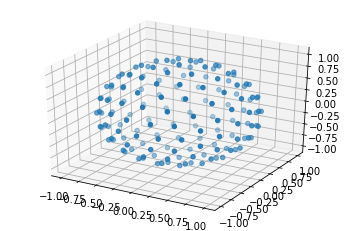

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

scale = 1
subdiv = 2

def vertex(x, y, z): 
    """ Return vertex coordinates fixed to the unit sphere 
    """ 
    length = sqrt(x**2 + y**2 + z**2) 
    return [(i * scale) / length for i in (x,y,z)]

middle_point_cache = {} 
def middle_point(point_1, point_2): 
    """ Find a middle point and project to the unit sphere 
    """ 
    
    # We check if we have already cut this edge first 
    # to avoid duplicated verts 
    smaller_index = min(point_1, point_2) 
    greater_index = max(point_1, point_2) 
    
    key = '{0}-{1}'.format(smaller_index, greater_index) 
    
    if key in middle_point_cache: 
        return middle_point_cache[key] 
        
    # If it's not in cache, then we can cut it 
    vert_1 = verts[point_1] 
    vert_2 = verts[point_2] 
    middle = [sum(i)/2 for i in zip(vert_1, vert_2)] 
    
    verts.append(vertex(*middle)) 
    
    index = len(verts) - 1 
    middle_point_cache[key] = index 
    
    return index

# -------------------------------------------------------------- 
# Make the base icosahedron 

# Golden ratio 
PHI = (1 + sqrt(5)) / 2 

verts = [ 
    vertex(-1, PHI, 0), 
    vertex( 1, PHI, 0), 
    vertex(-1, -PHI, 0), 
    vertex( 1, -PHI, 0), 
    vertex(0, -1, PHI), 
    vertex(0, 1, PHI), 
    vertex(0, -1, -PHI), 
    vertex(0, 1, -PHI), 
    vertex( PHI, 0, -1), 
    vertex( PHI, 0, 1), 
    vertex(-PHI, 0, -1), 
    vertex(-PHI, 0, 1), 
]
    
faces = [ 
    # 5 faces around point 0 
    [0, 11, 5], 
    [0, 5, 1], 
    [0, 1, 7], 
    [0, 7, 10], 
    [0, 10, 11], 
    
    # Adjacent faces 
    [1, 5, 9], 
    [5, 11, 4], 
    [11, 10, 2], 
    [10, 7, 6], 
    [7, 1, 8], 
    
    # 5 faces around 3 
    [3, 9, 4], 
    [3, 4, 2], 
    [3, 2, 6], 
    [3, 6, 8], 
    [3, 8, 9], 
    
    # Adjacent faces 
    [4, 9, 5], 
    [2, 4, 11], 
    [6, 2, 10], 
    [8, 6, 7], 
    [9, 8, 1], 
]
    
# Subdivisions 
# -------------------------------------------------------------- 
for i in range(subdiv): 
    faces_subdiv = [] 
    for tri in faces: 
        v1 = middle_point(tri[0], tri[1]) 
        v2 = middle_point(tri[1], tri[2]) 
        v3 = middle_point(tri[2], tri[0]) 
        
        faces_subdiv.append([tri[0], v1, v3]) 
        faces_subdiv.append([tri[1], v2, v1]) 
        faces_subdiv.append([tri[2], v3, v2]) 
        faces_subdiv.append([v1, v2, v3]) 
        
    faces = faces_subdiv
    
# plot
verts = np.array(verts).T
print(verts.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(verts[0,:], verts[1,:], verts[2,:])

plt.show()